In [5]:
import matplotlib.pyplot as plt
import numpy as np

from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF

In [6]:
aa = np.r_[1,3].tolist()
isinstance(aa,list)

True

**SumMap Demo**

In this notebook, we demonstrate how to use the SumMap. The example uses 

In [2]:
H0 = (50000, 90, 0)

# Create a mesh
dx = 5.

hxind = [(dx, 5, -1.3), (dx, 10), (dx, 5, 1.3)]
hyind = [(dx, 5, -1.3), (dx, 10), (dx, 5, 1.3)]
hzind = [(dx, 5, -1.3), (dx, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCC')

# Get index of the center
midx = int(mesh.nCx/2)
midy = int(mesh.nCy/2)

# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(mesh.vectorNx, mesh.vectorNy)
zz = -np.exp((xx**2 + yy**2) / 75**2) + mesh.vectorNz[-1]

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Go from topo to actv cells
actv = Utils.surface2ind_topo(mesh, topo, 'N')
actv = np.asarray([inds for inds, elem in enumerate(actv, 1) if elem],
                  dtype=int) - 1

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = len(actv)

# Create and array of observation points
xr = np.linspace(-20., 20., 20)
yr = np.linspace(-20., 20., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = -np.exp((X**2 + Y**2) / 75**2) + mesh.vectorNz[-1] + 5.

# Create a MAGsurvey
rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(rxLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField)

# We can now create a susceptibility model and generate data
model = np.zeros(mesh.nC)

# Change values in half the domain
model[mesh.gridCC[:,0] < 0] = 0.01

# Add a block in half-space
model = Utils.ModelBuilder.addBlock(mesh.gridCC, model, np.r_[-10,-10,20], np.r_[10,10,40], 0.05)

model = Utils.mkvc(model)
model = model[actv]




In [3]:
def plot_panels(m):
    ypanel = midx
    zpanel = -5

    m_lp = actvMap * m
    m_lp[m_lp == -100] = np.nan

    # # Plot the data
    # PF.Magnetics.plot_obs_2D(rxLoc, d=d)

    fig = plt.figure(figsize=(10,4))

    # Plot Lp model
    ax = plt.subplot(121)
    im = mesh.plotSlice(m_lp, ax=ax, normal='Z', ind=zpanel,
                   grid=True, clim=(m.min(), m.max()))
    plt.plot(([mesh.vectorCCx[0], mesh.vectorCCx[-1]]),
             ([mesh.vectorCCy[ypanel], mesh.vectorCCy[ypanel]]), color='w')
    plt.title('Plan lp-model.')
    plt.gca().set_aspect('equal')
    plt.colorbar(im[0])
    ax.xaxis.set_visible(False)
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')

    # Vertical section
    ax = plt.subplot(122)
    mesh.plotSlice(m_lp, ax=ax, normal='Y', ind=midx,
                   grid=True, clim=(m.min(), m.max()))
    plt.plot(([mesh.vectorCCx[0], mesh.vectorCCx[-1]]),
             ([mesh.vectorCCz[zpanel], mesh.vectorCCz[zpanel]]), color='w')
    plt.title('E-W lp-model.')
    plt.gca().set_aspect('equal')
    ax.xaxis.set_visible(False)
    plt.ylabel('z')
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()
    
    return fig

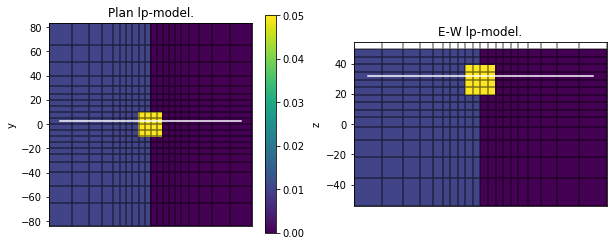

In [4]:
fig = plot_panels(model)
fig.savefig("TrueModel.png")

In [5]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, np.nan)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actv)

# Pair the survey and problem
survey.pair(prob)

# Compute linear forward operator and compute some data
d = prob.fields(model)

# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
data = d + np.random.randn(len(d))
wd = np.ones(len(data))*1.  # Assign flat uncertainties

survey.dobs = data
survey.std = wd
survey.mtrue = model

# Plot the data
rxLoc = survey.srcField.rxList[0].locs
# PF.Magnetics.plot_obs_2D(rxLoc, d=d)
# plt.show()

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



In [6]:
# Create sensitivity weights from our linear forward operator
rxLoc = survey.srcField.rxList[0].locs
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
# reg.norms = [0, 1, 1, 1]
# reg.eps_p, reg.eps_q = 1e-3, 1e-3

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+10)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+10  4.65e+06  0.00e+00  4.65e+06    6.29e+01      0              
   1  5.00e+09  4.18e+06  2.15e-05  4.28e+06    6.37e+01      0              
   2  2.50e+09  3.73e+06  8.56e-05  3.94e+06    6.28e+01      0   Skip BFGS  
   3  1.25e+09  3.09e+06  2.72e-04  3.43e+06    6.29e+01      0   Skip BFGS  
   4  6.25e+08  2.25e+06  7.55e-04  2.72e+06    6.18e+01      0   Skip BFGS  
   5  3.12e+08  1.39e+06  1.71e-03  1.93e+06    6.16e+01      0   Skip 

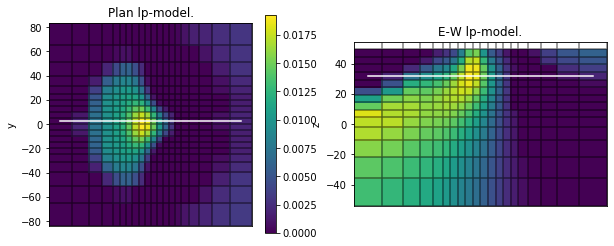

In [7]:
fig = plot_panels(mrec)
fig.savefig("Conventional.png")

Change the mapping to SumMap, first simple just double the existing model


In [8]:
# # Create active map to go from reduce set to full
# actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# # Creat reduced identity map
# idenMap = Maps.IdentityMap(nP=nC)

# # Create a SumMap that takes twice the same mapping
# sumMap = Maps.SumMap((idenMap,idenMap))

# # Create the forward model operator
# prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=sumMap, actInd=actv)

# # Pair the survey and problem
# survey.unpair()
# survey.pair(prob)

In [9]:
# # Create sensitivity weights from our linear forward operator
# wr = np.sum(prob.G**2., axis=0)**0.5
# wr = (wr/np.max(wr))

# # Create a regularization
# reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
# reg.cell_weights = wr
# # reg.norms = [0, 1, 1, 1]
# # reg.eps_p, reg.eps_q = 1e-3, 1e-3

# # Data misfit function
# dmis = DataMisfit.l2_DataMisfit(survey)
# dmis.W = 1/wd

# # Add directives to the inversion
# opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
#                                  maxIterLS=20, maxIterCG=10, tolCG=1e-3)
# invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
# betaest = Directives.BetaEstimate_ByEig()

# # Here is where the norms are applied
# # Use pick a treshold parameter empirically based on the distribution of
# #  model parameters
# IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)
# update_Jacobi = Directives.UpdatePreconditioner()
# inv = Inversion.BaseInversion(invProb,
#                               directiveList=[IRLS, betaest, update_Jacobi])

# # Run the inversion
# m0 = np.ones(nC)*1e-4  # Starting model
# mrecSum = inv.run(m0)

In [10]:
# fig = plot_panels(mrecSum)
# fig.savefig("SumMap_Double.png")

In [11]:
sumMap.deriv(np.ones(sumMap.shape[1])*1e-4)*np.ones(sumMap.shape[1])

NameError: name 'sumMap' is not defined

In [12]:
# Creat a homogenous maps for the two domains
domains = [mesh.gridCC[actv,0] < 0, mesh.gridCC[actv,0] >= 0]
homogMap = Maps.SurjectUnits(domains)

# Create a wire map for a second model space, voxel based
wires = Maps.Wires(('homo', len(domains)), ('hetero', len(actv)))

# Create Sum map
sumMap = Maps.SumMap([homogMap*wires.homo, wires.hetero])

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=sumMap, actInd=actv)

# Pair the survey and problem
survey.unpair()
survey.pair(prob)


In [13]:
# # Creat a homogenous maps for the two domains
# # domains = [mesh.gridCC[actv,0] < 0, mesh.gridCC[actv,0] >= 0]
# # homogMap = Maps.HomogeneousMap(domains)

# # Create a wire map for a second model space, voxel based
# wires = Maps.Wires(('homo', 2), ('hetero', len(actv)))

# # Create Sum map
# sumMap = Maps.SumMap([homogMap*wires.homo, wires.hetero])

# # Create the forward model operator
# prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=sumMap, actInd=actv)

# # Pair the survey and problem
# survey.unpair()
# survey.pair(prob)

In [14]:
# Make depth weighting
wr = np.zeros(sumMap.shape[1])

# Take the cell number out of the scaling.
# Want to keep high sens for large volumnes    
scale = Utils.sdiag(np.r_[Utils.mkvc(1./homogMap.P.sum(axis=0)),np.ones_like(actv)])

for ii in range(survey.nD):
    wr += ((prob.G[ii, :]*prob.chiMap.deriv(np.ones(sumMap.shape[1])*1e-4)*scale)/survey.std[ii])**2.

# Scale the model spaces independently
wr[wires.homo.index] /= (np.max((wires.homo*wr)))
wr[wires.hetero.index] /= (np.max(wires.hetero*wr))
wr = wr**0.5

Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



In [15]:
## Create a regularization
# For the homogeneous model
regMesh = Mesh.TensorMesh([len(domains)])

reg_m1 = Regularization.Sparse(regMesh, mapping=wires.homo)
reg_m1.cell_weights = wires.homo*wr
# reg_m1.norms = np.c_[0,2,2,2]
reg_m1.mref = np.zeros(sumMap.shape[1])

# Regularization for the voxel model
reg_m2 = Regularization.Sparse(mesh, indActive=actv, mapping=wires.hetero)
reg_m2.cell_weights = wires.hetero*wr
# reg_m2.norms = np.c_[0,1,1,1]
reg_m2.mref =  np.zeros(sumMap.shape[1])

reg = reg_m1 + reg_m2

In [16]:

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3, tolG=1e-3, eps=1e-6)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, betaest, update_Jacobi])

# Run the inversion
m0 = np.ones(sumMap.shape[1])*1e-4  # Starting model
prob.model = m0
mrecSum = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.73e+13  4.55e+06  1.72e-06  3.42e+07    7.47e-03      0              
   1  8.64e+12  4.61e+06  5.97e-07  9.77e+06    5.95e+01      0              
   2  4.32e+12  4.63e+06  2.37e-07  5.66e+06    6.45e+01      0   Skip BFGS  
   3  2.16e+12  4.63e+06  1.62e-07  4.98e+06    5.13e+01      0   Skip BFGS  
   4  1.08e+12  4.63e+06  1.18e-07  4.76e+06    6.04e+01      0   Skip BFGS  
   5  5.40e+11  4.63e+06  9.31e-08  4.68e+06    5.76e+01      0              
   6  2.70e+11  4.63e+06  8.70e-08  4.65e+06   

KeyboardInterrupt: 

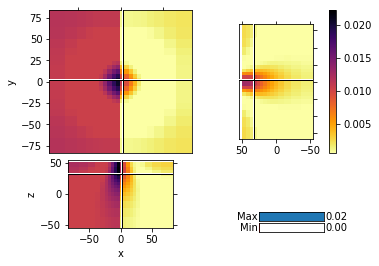

In [32]:
mesh.plot3DSlicer(actvMap * sumMap * mrecSum, aspect="equal",zslice=30, pcolorOpts={"cmap":'inferno_r'}, transparent='slider')


In [ ]:
97096289569.80829 284.88836560453126
135553084149.9695 0.7847671279344808